# Machine Learning with PyTorch and Scikit-Learn  

## Sagiv Antebi - 318159282

## Ron Solomon - 315589507

In [1]:
import sys
sys.path.insert(0, '..')

In [6]:
from sklearn.datasets import fetch_openml


X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.values
y = y.astype(int).values

print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


Normalize to [-1, 1] range:

In [7]:
X = ((X / 255.) - .5) * 2

Visualize the first digit of each class:

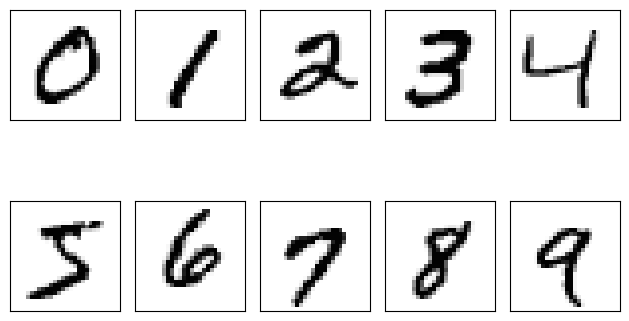

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X[y == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('figures/11_4.png', dpi=300)
plt.show()

Visualize 25 different versions of "7":

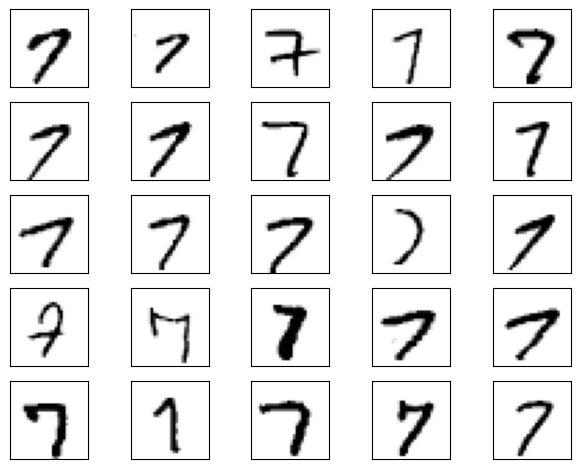

In [9]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = X[y == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('figures/11_5.png', dpi=300)
plt.show()

Split into training, validation, and test set:

In [10]:
from sklearn.model_selection import train_test_split


X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=10000, random_state=123, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=5000, random_state=123, stratify=y_temp)


# optional to free up some memory by deleting non-used arrays:
del X_temp, y_temp, X, y

<br>
<br>

#One-Layer Perceptron

In [11]:
import numpy as np

In [12]:
##########################
### MODEL
##########################

def sigmoid(z):
    return 1. / (1. + np.exp(-z))


def int_to_onehot(y, num_labels):

    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1

    return ary


class NeuralNetMLP:

    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__()

        self.num_classes = num_classes

        # hidden
        rng = np.random.RandomState(random_seed)

        self.weight_h = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h = np.zeros(num_hidden)

        # output
        self.weight_out = rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)

    def forward(self, x):
        # Hidden layer
        # input dim: [n_examples, n_features] dot [n_hidden, n_features].T
        # output dim: [n_examples, n_hidden]
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        a_h = sigmoid(z_h)

        # Output layer
        # input dim: [n_examples, n_hidden] dot [n_classes, n_hidden].T
        # output dim: [n_examples, n_classes]
        z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h, a_out

    def backward(self, x, a_h, a_out, y):

        #########################
        ### Output layer weights
        #########################

        # onehot encoding
        y_onehot = int_to_onehot(y, self.num_classes)

        # Part 1: dLoss/dOutWeights
        ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
        ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
        ## for convenient re-use

        # input/output dim: [n_examples, n_classes]
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]

        # input/output dim: [n_examples, n_classes]
        d_a_out__d_z_out = a_out * (1. - a_out) # sigmoid derivative

        # output dim: [n_examples, n_classes]
        delta_out = d_loss__d_a_out * d_a_out__d_z_out # "delta (rule) placeholder"

        # gradient for output weights

        # [n_examples, n_hidden]
        d_z_out__dw_out = a_h

        # input dim: [n_classes, n_examples] dot [n_examples, n_hidden]
        # output dim: [n_classes, n_hidden]
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)


        #################################
        # Part 2: dLoss/dHiddenWeights
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeight

        # [n_classes, n_hidden]
        d_z_out__a_h = self.weight_out

        # output dim: [n_examples, n_hidden]
        d_loss__a_h = np.dot(delta_out, d_z_out__a_h)

        # [n_examples, n_hidden]
        d_a_h__d_z_h = a_h * (1. - a_h) # sigmoid derivative

        # [n_examples, n_features]
        d_z_h__d_w_h = x

        # output dim: [n_hidden, n_features]
        d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h)
        d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)

        return (d_loss__dw_out, d_loss__db_out,
                d_loss__d_w_h, d_loss__d_b_h)

In [13]:
model = NeuralNetMLP(num_features=28*28,
                     num_hidden=50,
                     num_classes=10)

In [14]:
import numpy as np

num_epochs = 50
minibatch_size = 100


def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    for start_idx in range(0, indices.shape[0] - minibatch_size
                           + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]

        yield X[batch_idx], y[batch_idx]


# iterate over training epochs
for i in range(num_epochs):

    # iterate over minibatches
    minibatch_gen = minibatch_generator(
        X_train, y_train, minibatch_size)

    for X_train_mini, y_train_mini in minibatch_gen:

        break

    break

print(X_train_mini.shape)
print(y_train_mini.shape)

(100, 784)
(100,)


In [15]:
def mse_loss(targets, probas, num_labels=10):
    onehot_targets = int_to_onehot(targets, num_labels=num_labels)
    return np.mean((onehot_targets - probas)**2)


def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets)


_, probas = model.forward(X_valid)
mse = mse_loss(y_valid, probas)

predicted_labels = np.argmax(probas, axis=1)
acc = accuracy(y_valid, predicted_labels)

print(f'Initial validation MSE: {mse:.1f}')
print(f'Initial validation accuracy: {acc*100:.1f}%')

Initial validation MSE: 0.3
Initial validation accuracy: 9.4%


In [76]:
def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)

    for i, (features, targets) in enumerate(minibatch_gen):

        _, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)

        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas)**2)
        correct_pred += (predicted_labels == targets).sum()

        num_examples += targets.shape[0]
        mse += loss

    mse = mse/(i+1)
    acc = correct_pred/num_examples
    return mse, acc

In [77]:
mse, acc = compute_mse_and_acc(model, X_valid, y_valid)
print(f'Initial valid MSE: {mse:.1f}')
print(f'Initial valid accuracy: {acc*100:.1f}%')

Initial valid MSE: 0.0
Initial valid accuracy: 94.2%


In [18]:
def train(model, X_train, y_train, X_valid, y_valid, num_epochs,
          learning_rate=0.1):

    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []

    for e in range(num_epochs):

        # iterate over minibatches
        minibatch_gen = minibatch_generator(
            X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:

            #### Compute outputs ####
            a_h, a_out = model.forward(X_train_mini)

            #### Compute gradients ####
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h, d_loss__d_b_h = \
                model.backward(X_train_mini, a_h, a_out, y_train_mini)

            #### Update weights ####
            model.weight_h -= learning_rate * d_loss__d_w_h
            model.bias_h -= learning_rate * d_loss__d_b_h
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out

        #### Epoch Logging ####
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)
        train_acc, valid_acc = train_acc*100, valid_acc*100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}%')

    return epoch_loss, epoch_train_acc, epoch_valid_acc

In [78]:
np.random.seed(123) # for the training set shuffling



epoch_loss, epoch_train_acc, epoch_valid_acc = train(
    model, X_train, y_train, X_valid, y_valid,
    num_epochs=50, learning_rate=0.1)

Epoch: 001/050 | Train MSE: 0.01 | Train Acc: 94.73% | Valid Acc: 94.10%
Epoch: 002/050 | Train MSE: 0.01 | Train Acc: 94.77% | Valid Acc: 93.96%
Epoch: 003/050 | Train MSE: 0.01 | Train Acc: 94.83% | Valid Acc: 93.96%
Epoch: 004/050 | Train MSE: 0.01 | Train Acc: 94.88% | Valid Acc: 93.78%
Epoch: 005/050 | Train MSE: 0.01 | Train Acc: 94.93% | Valid Acc: 93.60%
Epoch: 006/050 | Train MSE: 0.01 | Train Acc: 94.90% | Valid Acc: 93.42%
Epoch: 007/050 | Train MSE: 0.01 | Train Acc: 94.98% | Valid Acc: 93.24%
Epoch: 008/050 | Train MSE: 0.01 | Train Acc: 95.04% | Valid Acc: 93.02%
Epoch: 009/050 | Train MSE: 0.01 | Train Acc: 95.10% | Valid Acc: 92.94%
Epoch: 010/050 | Train MSE: 0.01 | Train Acc: 95.10% | Valid Acc: 92.72%
Epoch: 011/050 | Train MSE: 0.01 | Train Acc: 95.14% | Valid Acc: 92.56%
Epoch: 012/050 | Train MSE: 0.01 | Train Acc: 95.20% | Valid Acc: 92.32%
Epoch: 013/050 | Train MSE: 0.01 | Train Acc: 95.22% | Valid Acc: 92.18%
Epoch: 014/050 | Train MSE: 0.01 | Train Acc: 95.30

## Evaluating the neural network performance

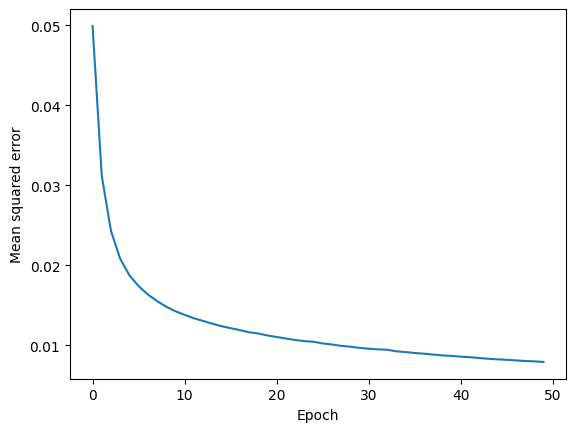

In [20]:
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
#plt.savefig('figures/11_07.png', dpi=300)
plt.show()

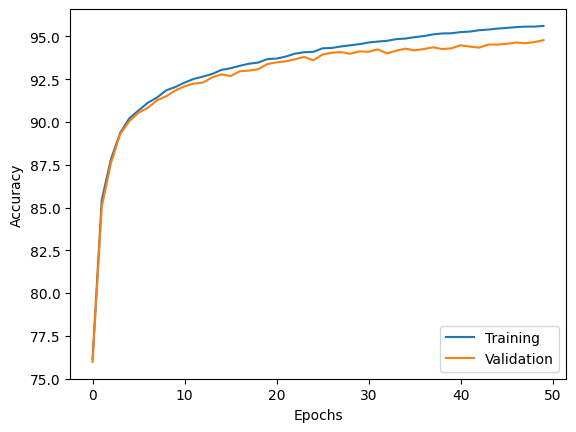

In [21]:
plt.plot(range(len(epoch_train_acc)), epoch_train_acc,
         label='Training')
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc,
         label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
#plt.savefig('figures/11_08.png', dpi=300)
plt.show()

In [22]:
test_mse, test_acc = compute_mse_and_acc(model, X_test, y_test)
print(f'Test accuracy: {test_acc*100:.2f}%')

Test accuracy: 94.54%


Plot failure cases:

In [ ]:
X_test_subset = X_test[:1000, :]
y_test_subset = y_test[:1000]

_, probas = model.forward(X_test_subset)
test_pred = np.argmax(probas, axis=1)

misclassified_images = X_test_subset[y_test_subset != test_pred][:25]
misclassified_labels = test_pred[y_test_subset != test_pred][:25]
correct_labels = y_test_subset[y_test_subset != test_pred][:25]

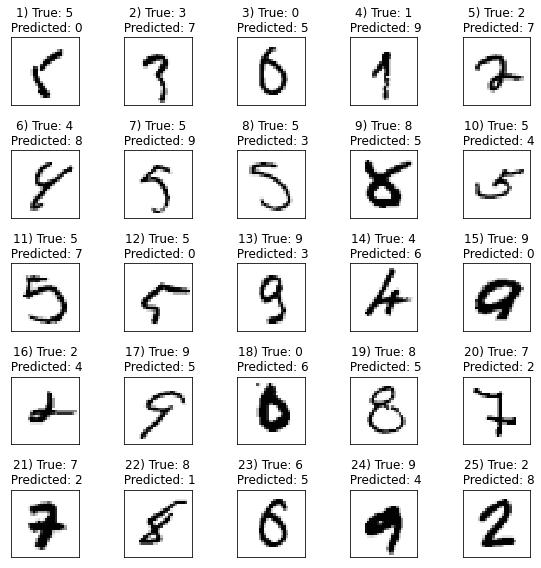

In [ ]:
fig, ax = plt.subplots(nrows=5, ncols=5,
                       sharex=True, sharey=True, figsize=(8, 8))
ax = ax.flatten()
for i in range(25):
    img = misclassified_images[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title(f'{i+1}) '
                    f'True: {correct_labels[i]}\n'
                    f' Predicted: {misclassified_labels[i]}')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('figures/11_09.png', dpi=300)
plt.show()

<br>
<br>

#Task 2: Two-Layer Perceptron

## Implementing a 2-layer perceptron

In [23]:
import numpy as np

In [24]:
class NeuralNetMLP2Hidden:
    def __init__(self, num_features, num_hidden1, num_hidden2,
                 num_classes, random_seed=123):
        super().__init__()

        self.num_classes = num_classes

        rng = np.random.RandomState(random_seed)

        # First hidden layer
        self.weight_h1 = rng.normal(loc=0.0, scale=0.1,
                                    size=(num_hidden1, num_features))
        self.bias_h1 = np.zeros(num_hidden1)

        # Second hidden layer
        self.weight_h2 = rng.normal(loc=0.0, scale=0.1,
                                    size=(num_hidden2, num_hidden1))
        self.bias_h2 = np.zeros(num_hidden2)

        # Output layer
        self.weight_out = rng.normal(loc=0.0, scale=0.1,
                                     size=(num_classes, num_hidden2))
        self.bias_out = np.zeros(num_classes)

    def forward(self, x):
        # First hidden layer
        z_h1 = np.dot(x, self.weight_h1.T) + self.bias_h1
        a_h1 = sigmoid(z_h1)

        # Second hidden layer
        z_h2 = np.dot(a_h1, self.weight_h2.T) + self.bias_h2
        a_h2 = sigmoid(z_h2)

        # Output layer
        z_out = np.dot(a_h2, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)

        return a_h1, a_h2, a_out

    def backward(self, x, a_h1, a_h2, a_out, y):
        # One-hot encoding of the targets
        y_onehot = int_to_onehot(y, self.num_classes)

        # Compute delta for output layer
        d_loss__d_a_out = 2.0 * (a_out - y_onehot) / y.shape[0]
        d_a_out__d_z_out = a_out * (1.0 - a_out)  # sigmoid derivative
        delta_out = d_loss__d_a_out * d_a_out__d_z_out

        # Gradients for output layer
        d_z_out__dw_out = a_h2  # shape = [n_examples, num_hidden2]
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)

        # Backprop to second hidden layer
        d_z_out__a_h2 = self.weight_out  # shape = [num_classes, num_hidden2]
        d_loss__a_h2 = np.dot(delta_out, d_z_out__a_h2)
        d_a_h2__d_z_h2 = a_h2 * (1.0 - a_h2)  # sigmoid derivative
        delta_h2 = d_loss__a_h2 * d_a_h2__d_z_h2

        # Gradients for second hidden layer
        d_z_h2__dw_h2 = a_h1  # shape = [n_examples, num_hidden1]
        d_loss__dw_h2 = np.dot(delta_h2.T, d_z_h2__dw_h2)
        d_loss__db_h2 = np.sum(delta_h2, axis=0)

        # Backprop to first hidden layer
        d_z_h2__a_h1 = self.weight_h2  # shape = [num_hidden2, num_hidden1]
        d_loss__a_h1 = np.dot(delta_h2, d_z_h2__a_h1)
        d_a_h1__d_z_h1 = a_h1 * (1.0 - a_h1)  # sigmoid derivative
        delta_h1 = d_loss__a_h1 * d_a_h1__d_z_h1

        # Gradients for first hidden layer
        d_z_h1__dw_h1 = x  # shape = [n_examples, num_features]
        d_loss__dw_h1 = np.dot(delta_h1.T, d_z_h1__dw_h1)
        d_loss__db_h1 = np.sum(delta_h1, axis=0)

        return (d_loss__dw_out, d_loss__db_out,
                d_loss__dw_h2, d_loss__db_h2,
                d_loss__dw_h1, d_loss__db_h1)


In [25]:
model_2hidden = NeuralNetMLP2Hidden(
    num_features=28*28,
    num_hidden1=50,
    num_hidden2=50,
    num_classes=10,
    random_seed=123
)

## Coding the neural network training loop

In [26]:
import numpy as np

num_epochs = 50
minibatch_size = 100


def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    for start_idx in range(0, indices.shape[0] - minibatch_size
                           + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]

        yield X[batch_idx], y[batch_idx]


# iterate over training epochs
for i in range(num_epochs):

    # iterate over minibatches
    minibatch_gen = minibatch_generator(
        X_train, y_train, minibatch_size)

    for X_train_mini, y_train_mini in minibatch_gen:

        break

    break

print(X_train_mini.shape)
print(y_train_mini.shape)

(100, 784)
(100,)


Defining a function to compute the loss and accuracy

In [27]:
def mse_loss(targets, probas, num_labels=10):
    onehot_targets = int_to_onehot(targets, num_labels=num_labels)
    return np.mean((onehot_targets - probas)**2)


def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets)


_, probas = model.forward(X_valid)
mse = mse_loss(y_valid, probas)

predicted_labels = np.argmax(probas, axis=1)
acc = accuracy(y_valid, predicted_labels)

print(f'Initial validation MSE: {mse:.1f}')
print(f'Initial validation accuracy: {acc*100:.1f}%')

Initial validation MSE: 0.0
Initial validation accuracy: 94.8%


In [28]:
def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)

    for i, (features, targets) in enumerate(minibatch_gen):

        _, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)

        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas)**2)
        correct_pred += (predicted_labels == targets).sum()

        num_examples += targets.shape[0]
        mse += loss

    mse = mse/(i+1)
    acc = correct_pred/num_examples
    return mse, acc

In [29]:
mse, acc = compute_mse_and_acc(model, X_valid, y_valid)
print(f'Initial valid MSE: {mse:.1f}')
print(f'Initial valid accuracy: {acc*100:.1f}%')

Initial valid MSE: 0.0
Initial valid accuracy: 94.8%


In [39]:
def train_2hidden(model, X_train, y_train, X_valid, y_valid,
                  num_epochs=50, learning_rate=0.1, minibatch_size=100):
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []

    for e in range(num_epochs):

        # iterate over minibatches
        minibatch_gen = minibatch_generator(X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:

            # Forward pass
            a_h1, a_h2, a_out = model.forward(X_train_mini)

            # Backward pass
            (d_loss__dw_out, d_loss__db_out,
             d_loss__dw_h2, d_loss__db_h2,
             d_loss__dw_h1, d_loss__db_h1) = \
                model.backward(X_train_mini, a_h1, a_h2, a_out, y_train_mini)

            # Parameter updates
            model.weight_out -= learning_rate * d_loss__dw_out
            model.bias_out   -= learning_rate * d_loss__db_out

            model.weight_h2  -= learning_rate * d_loss__dw_h2
            model.bias_h2    -= learning_rate * d_loss__db_h2

            model.weight_h1  -= learning_rate * d_loss__dw_h1
            model.bias_h1    -= learning_rate * d_loss__db_h1

        # Logging after each epoch
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)

        epoch_loss.append(train_mse)
        epoch_train_acc.append(train_acc * 100)
        epoch_valid_acc.append(valid_acc * 100)

        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc*100:.2f}% '
              f'| Valid Acc: {valid_acc*100:.2f}%')


    return epoch_loss, epoch_train_acc, epoch_valid_acc


In [64]:
def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)

    for i, (features, targets) in enumerate(minibatch_gen):
        # For two-hidden-layer model:
        _, _, probas = nnet.forward(features)

        predicted_labels = np.argmax(probas, axis=1)
        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas)**2)

        correct_pred += (predicted_labels == targets).sum()
        num_examples += targets.shape[0]
        mse += loss

    mse = mse/(i+1)
    acc = correct_pred/num_examples
    return mse, acc

In [59]:
np.random.seed(123) # for the training set shuffling

epoch_loss_2hidden, epoch_train_acc_2hidden, epoch_valid_acc_2hidden = train_2hidden(
    model=model_2hidden,
    X_train=X_train,
    y_train=y_train,
    X_valid=X_valid,
    y_valid=y_valid,
    num_epochs=50,
    learning_rate=0.1,
    minibatch_size=100
)

Epoch: 001/050 | Train MSE: 0.00 | Train Acc: 97.87% | Valid Acc: 95.96%
Epoch: 002/050 | Train MSE: 0.00 | Train Acc: 97.85% | Valid Acc: 95.90%
Epoch: 003/050 | Train MSE: 0.00 | Train Acc: 97.93% | Valid Acc: 96.04%
Epoch: 004/050 | Train MSE: 0.00 | Train Acc: 97.93% | Valid Acc: 96.14%
Epoch: 005/050 | Train MSE: 0.00 | Train Acc: 97.97% | Valid Acc: 96.08%
Epoch: 006/050 | Train MSE: 0.00 | Train Acc: 97.92% | Valid Acc: 95.90%
Epoch: 007/050 | Train MSE: 0.00 | Train Acc: 98.00% | Valid Acc: 96.08%
Epoch: 008/050 | Train MSE: 0.00 | Train Acc: 97.99% | Valid Acc: 96.16%
Epoch: 009/050 | Train MSE: 0.00 | Train Acc: 98.02% | Valid Acc: 96.14%
Epoch: 010/050 | Train MSE: 0.00 | Train Acc: 98.03% | Valid Acc: 96.06%
Epoch: 011/050 | Train MSE: 0.00 | Train Acc: 98.05% | Valid Acc: 96.12%
Epoch: 012/050 | Train MSE: 0.00 | Train Acc: 98.03% | Valid Acc: 96.08%
Epoch: 013/050 | Train MSE: 0.00 | Train Acc: 98.09% | Valid Acc: 96.10%
Epoch: 014/050 | Train MSE: 0.00 | Train Acc: 98.06

## Evaluating the neural network performance

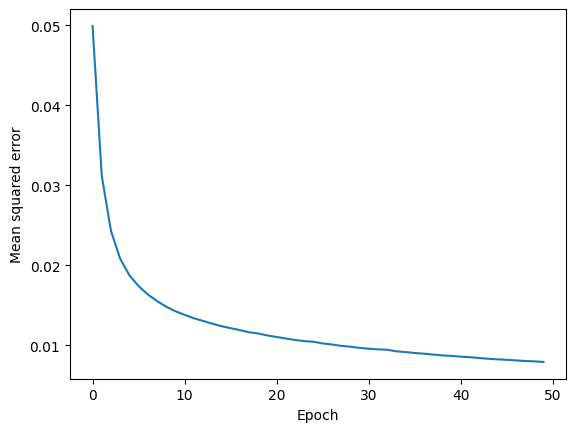

In [60]:
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
#plt.savefig('figures/11_07.png', dpi=300)
plt.show()

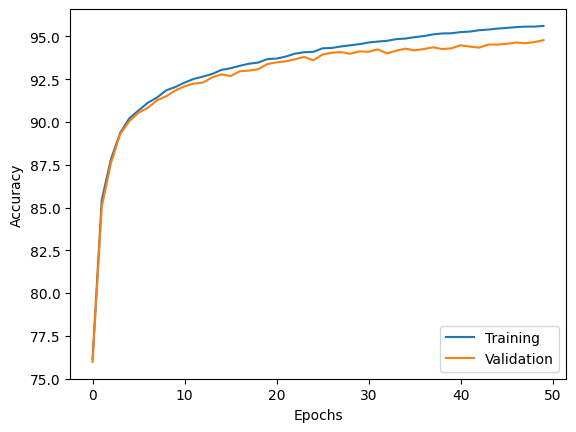

In [61]:
plt.plot(range(len(epoch_train_acc)), epoch_train_acc,
         label='Training')
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc,
         label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
#plt.savefig('figures/11_08.png', dpi=300)
plt.show()

In [66]:
test_mse, test_acc = compute_mse_and_acc(model_2hidden, X_test, y_test)
print(f'Test accuracy: {test_acc*100:.2f}%')

Test accuracy: 96.57%


Plot failure cases:

In [67]:
X_test_subset = X_test[:1000, :]
y_test_subset = y_test[:1000]

_, probas = model.forward(X_test_subset)
test_pred = np.argmax(probas, axis=1)

misclassified_images = X_test_subset[y_test_subset != test_pred][:25]
misclassified_labels = test_pred[y_test_subset != test_pred][:25]
correct_labels = y_test_subset[y_test_subset != test_pred][:25]

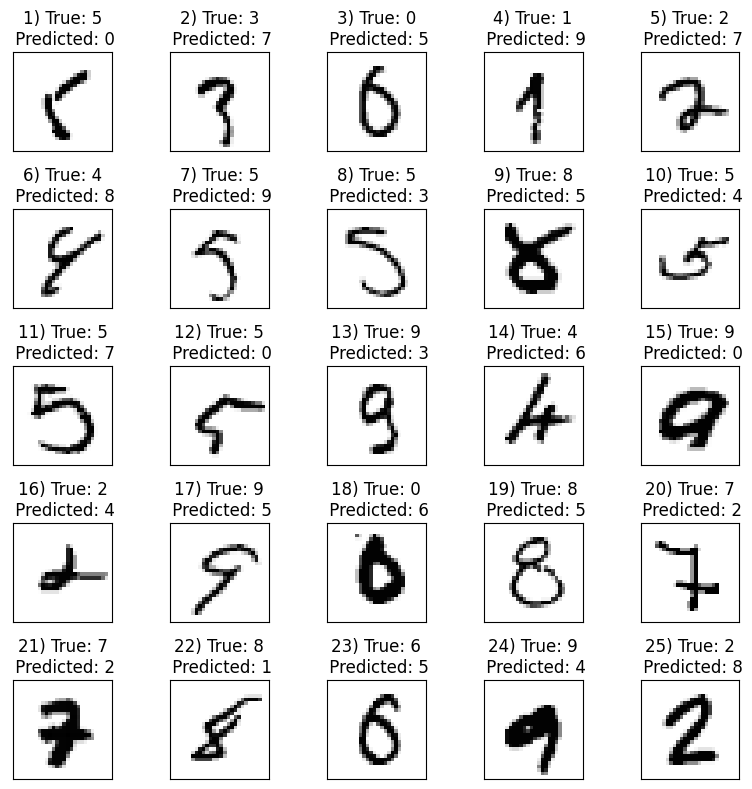

In [68]:
fig, ax = plt.subplots(nrows=5, ncols=5,
                       sharex=True, sharey=True, figsize=(8, 8))
ax = ax.flatten()
for i in range(25):
    img = misclassified_images[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title(f'{i+1}) '
                    f'True: {correct_labels[i]}\n'
                    f' Predicted: {misclassified_labels[i]}')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('figures/11_09.png', dpi=300)
plt.show()

<br>
<br>

# Task 3:  ANN architecture (with Kears)

In [80]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from tensorflow.keras.datasets import mnist
import math

In [81]:
# Load original MNIST from Keras
(X_train_full, y_train_full), (X_test_full, y_test_full) = mnist.load_data()

# Combine everything into a single dataset of size 70k
X_all = np.concatenate([X_train_full, X_test_full], axis=0)
y_all = np.concatenate([y_train_full, y_test_full], axis=0)

# Flatten each 28x28 image into a 1D vector of length 784
X_all = X_all.reshape(X_all.shape[0], 28*28).astype(np.float32)

# Normalize inputs to [0, 1]
X_all /= 255.0

# 70% train, 30% test
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.30, random_state=123, shuffle=True)

print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Test set:  {X_test.shape}, {y_test.shape}")

Train set: (49000, 784), (49000,)
Test set:  (21000, 784), (21000,)


In [82]:
def sigmoid(z):
    return 1. / (1. + np.exp(-z))

def int_to_onehot(y, num_labels):
    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1
    return ary

def minibatch_generator(X, y, minibatch_size=100):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    for start_idx in range(0, indices.shape[0] - minibatch_size + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]
        yield X[batch_idx], y[batch_idx]

def macro_auc_score(y_true, probas, num_classes=10):
    y_onehot = int_to_onehot(y_true, num_labels=num_classes)
    return roc_auc_score(y_onehot, probas, average='macro', multi_class='ovr')

In [83]:
class NeuralNetMLP_1Hidden:
    """Single-hidden-layer MLP"""

    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__()
        self.num_classes = num_classes
        rng = np.random.RandomState(random_seed)

        # Hidden layer
        self.weight_h = rng.normal(loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h = np.zeros(num_hidden)

        # Output layer
        self.weight_out = rng.normal(loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)

    def forward(self, x):
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        a_h = sigmoid(z_h)
        z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h, a_out

    def backward(self, x, a_h, a_out, y):
        # one-hot
        y_onehot = int_to_onehot(y, self.num_classes)

        d_loss__d_a_out = 2.0 * (a_out - y_onehot) / y.shape[0]
        d_a_out__d_z_out = a_out * (1. - a_out)
        delta_out = d_loss__d_a_out * d_a_out__d_z_out

        # Output layer
        d_z_out__dw_out = a_h
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)

        # Hidden layer
        d_z_out__a_h = self.weight_out
        d_loss__a_h = np.dot(delta_out, d_z_out__a_h)
        d_a_h__d_z_h = a_h * (1. - a_h)
        delta_h = d_loss__a_h * d_a_h__d_z_h

        d_z_h__d_w_h = x
        d_loss__d_w_h = np.dot(delta_h.T, d_z_h__d_w_h)
        d_loss__d_b_h = np.sum(delta_h, axis=0)

        return (d_loss__dw_out, d_loss__db_out,
                d_loss__d_w_h, d_loss__d_b_h)

def train_1hidden(model, X_train, y_train, X_test, y_test,
                  num_epochs=10, learning_rate=0.1, minibatch_size=100):
    # Simple training loop
    for e in range(num_epochs):
        minibatch_gen = minibatch_generator(X_train, y_train, minibatch_size)
        for X_mini, y_mini in minibatch_gen:
            a_h, a_out = model.forward(X_mini)
            (dW_out, dB_out, dW_h, dB_h) = model.backward(X_mini, a_h, a_out, y_mini)

            # Update
            model.weight_out -= learning_rate * dW_out
            model.bias_out   -= learning_rate * dB_out
            model.weight_h   -= learning_rate * dW_h
            model.bias_h     -= learning_rate * dB_h

        # Logging AUC after each epoch
        # forward on the test set
        _, test_probas = model.forward(X_test)
        test_auc = macro_auc_score(y_test, test_probas, num_classes=model.num_classes)
        print(f"[Epoch {e+1:02d}] Test Macro AUC: {test_auc:.3f}")


In [84]:
# Single Hidden Layer
model_1hidden = NeuralNetMLP_1Hidden(
    num_features=784,  # 28*28
    num_hidden=100,    # example hidden dimension
    num_classes=10,
    random_seed=123
)

print("Training Single-Hidden-Layer MLP:")
train_1hidden(
    model=model_1hidden,
    X_train=X_train, y_train=y_train,
    X_test=X_test,   y_test=y_test,
    num_epochs=10,   learning_rate=0.1,   minibatch_size=100
)

Training Single-Hidden-Layer MLP:
[Epoch 01] Test Macro AUC: 0.950
[Epoch 02] Test Macro AUC: 0.965
[Epoch 03] Test Macro AUC: 0.972
[Epoch 04] Test Macro AUC: 0.975
[Epoch 05] Test Macro AUC: 0.978
[Epoch 06] Test Macro AUC: 0.979
[Epoch 07] Test Macro AUC: 0.980
[Epoch 08] Test Macro AUC: 0.981
[Epoch 09] Test Macro AUC: 0.982
[Epoch 10] Test Macro AUC: 0.983


In [85]:
class NeuralNetMLP_2Hidden:
    """Two-hidden-layer MLP."""

    def __init__(self, num_features, num_hidden1, num_hidden2,
                 num_classes, random_seed=123):
        super().__init__()
        self.num_classes = num_classes

        rng = np.random.RandomState(random_seed)

        # First hidden layer
        self.weight_h1 = rng.normal(loc=0.0, scale=0.1, size=(num_hidden1, num_features))
        self.bias_h1 = np.zeros(num_hidden1)

        # Second hidden layer
        self.weight_h2 = rng.normal(loc=0.0, scale=0.1, size=(num_hidden2, num_hidden1))
        self.bias_h2 = np.zeros(num_hidden2)

        # Output layer
        self.weight_out = rng.normal(loc=0.0, scale=0.1, size=(num_classes, num_hidden2))
        self.bias_out = np.zeros(num_classes)

    def forward(self, x):
        z_h1 = np.dot(x, self.weight_h1.T) + self.bias_h1
        a_h1 = sigmoid(z_h1)

        z_h2 = np.dot(a_h1, self.weight_h2.T) + self.bias_h2
        a_h2 = sigmoid(z_h2)

        z_out = np.dot(a_h2, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)

        return a_h1, a_h2, a_out

    def backward(self, x, a_h1, a_h2, a_out, y):
        y_onehot = int_to_onehot(y, self.num_classes)

        # Output layer
        d_loss__d_a_out = 2.0 * (a_out - y_onehot) / y.shape[0]
        d_a_out__d_z_out = a_out * (1. - a_out)
        delta_out = d_loss__d_a_out * d_a_out__d_z_out

        d_z_out__dw_out = a_h2
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)

        # Second hidden layer
        d_z_out__a_h2 = self.weight_out
        d_loss__a_h2 = np.dot(delta_out, d_z_out__a_h2)
        d_a_h2__d_z_h2 = a_h2 * (1. - a_h2)
        delta_h2 = d_loss__a_h2 * d_a_h2__d_z_h2

        d_z_h2__dw_h2 = a_h1
        d_loss__dw_h2 = np.dot(delta_h2.T, d_z_h2__dw_h2)
        d_loss__db_h2 = np.sum(delta_h2, axis=0)

        # First hidden layer
        d_z_h2__a_h1 = self.weight_h2
        d_loss__a_h1 = np.dot(delta_h2, d_z_h2__a_h1)
        d_a_h1__d_z_h1 = a_h1 * (1. - a_h1)
        delta_h1 = d_loss__a_h1 * d_a_h1__d_z_h1

        d_z_h1__dw_h1 = x
        d_loss__dw_h1 = np.dot(delta_h1.T, d_z_h1__dw_h1)
        d_loss__db_h1 = np.sum(delta_h1, axis=0)

        return (d_loss__dw_out, d_loss__db_out,
                d_loss__dw_h2, d_loss__db_h2,
                d_loss__dw_h1, d_loss__db_h1)

def train_2hidden(model, X_train, y_train, X_test, y_test,
                  num_epochs=10, learning_rate=0.1, minibatch_size=100):

    for e in range(num_epochs):
        minibatch_gen = minibatch_generator(X_train, y_train, minibatch_size)

        for X_mini, y_mini in minibatch_gen:
            a_h1, a_h2, a_out = model.forward(X_mini)
            (dW_out, dB_out, dW_h2, dB_h2, dW_h1, dB_h1) = \
                model.backward(X_mini, a_h1, a_h2, a_out, y_mini)

            # Update
            model.weight_out -= learning_rate * dW_out
            model.bias_out   -= learning_rate * dB_out

            model.weight_h2  -= learning_rate * dW_h2
            model.bias_h2    -= learning_rate * dB_h2

            model.weight_h1  -= learning_rate * dW_h1
            model.bias_h1    -= learning_rate * dB_h1

        # Logging macro AUC
        _, _, test_probas = model.forward(X_test)
        test_auc = macro_auc_score(y_test, test_probas, num_classes=model.num_classes)
        print(f"[Epoch {e+1:02d}] Test Macro AUC: {test_auc:.3f}")

In [86]:
# Two Hidden Layers
model_2hidden = NeuralNetMLP_2Hidden(
    num_features=784,
    num_hidden1=100,
    num_hidden2=100,
    num_classes=10,
    random_seed=123
)

print("\nTraining Two-Hidden-Layer MLP:")
train_2hidden(
    model=model_2hidden,
    X_train=X_train, y_train=y_train,
    X_test=X_test,   y_test=y_test,
    num_epochs=10,   learning_rate=0.1,   minibatch_size=100
)


Training Two-Hidden-Layer MLP:
[Epoch 01] Test Macro AUC: 0.835
[Epoch 02] Test Macro AUC: 0.893
[Epoch 03] Test Macro AUC: 0.907
[Epoch 04] Test Macro AUC: 0.930
[Epoch 05] Test Macro AUC: 0.946
[Epoch 06] Test Macro AUC: 0.958
[Epoch 07] Test Macro AUC: 0.964
[Epoch 08] Test Macro AUC: 0.969
[Epoch 09] Test Macro AUC: 0.972
[Epoch 10] Test Macro AUC: 0.975


In [87]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Build a 2-hidden-layer feedforward network with ReLU (or Sigmoid)
model_keras = keras.Sequential([
    layers.Input(shape=(784,)),
    layers.Dense(100, activation='sigmoid'),
    layers.Dense(100, activation='sigmoid'),
    layers.Dense(10, activation='softmax')
])

model_keras.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    metrics=['accuracy']
)

# Convert y_train/y_test to one-hot for training in Keras
y_train_oh = keras.utils.to_categorical(y_train, num_classes=10)
y_test_oh  = keras.utils.to_categorical(y_test,  num_classes=10)

history = model_keras.fit(
    X_train, y_train_oh,
    validation_data=(X_test, y_test_oh),
    epochs=10, batch_size=100
)

Epoch 1/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8156 - loss: 0.5965 - val_accuracy: 0.9535 - val_loss: 0.1459
Epoch 2/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9617 - loss: 0.1227 - val_accuracy: 0.9630 - val_loss: 0.1215
Epoch 3/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9714 - loss: 0.0899 - val_accuracy: 0.9625 - val_loss: 0.1190
Epoch 4/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9784 - loss: 0.0669 - val_accuracy: 0.9669 - val_loss: 0.1133
Epoch 5/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9823 - loss: 0.0544 - val_accuracy: 0.9681 - val_loss: 0.1087
Epoch 6/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9830 - loss: 0.0502 - val_accuracy: 0.9661 - val_loss: 0.1158
Epoch 7/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9845 - loss: 0.0449 - val_accuracy: 0.9690 - val_loss: 0.1167
Epoch 8/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9879 - loss: 0.0383 - val_accuracy: 0.

In [88]:
test_probas_keras = model_keras.predict(X_test)  # shape [n_test, 10]
# y_test are integer labels
keras_macro_auc = roc_auc_score(
    int_to_onehot(y_test, 10),
    test_probas_keras,
    average='macro',
    multi_class='ovr'
)

print(f"Keras Model - Test Macro AUC: {keras_macro_auc:.3f}")

657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Keras Model - Test Macro AUC: 0.999


# Task 4: Compare the models

In [89]:
# Single-Hidden-Layer final AUC
_, test_probas_1hidden = model.forward(X_test)
auc_1hidden = macro_auc_score(y_test, test_probas_1hidden)
print(f"Single-Hidden-Layer MLP - Test Macro AUC: {auc_1hidden:.3f}")

# Two-Hidden-Layer final AUC
_, _, test_probas_2hidden = model_2hidden.forward(X_test)
auc_2hidden = macro_auc_score(y_test, test_probas_2hidden)
print(f"Two-Hidden-Layer MLP - Test Macro AUC: {auc_2hidden:.3f}")

# Keras model AUC
print(f"Keras Two-Hidden-Layer MLP - Test Macro AUC: {keras_macro_auc:.3f}")

Single-Hidden-Layer MLP - Test Macro AUC: 0.995
Two-Hidden-Layer MLP - Test Macro AUC: 0.975
Keras Two-Hidden-Layer MLP - Test Macro AUC: 0.999


# Training an artificial neural network

...

## Computing the loss function

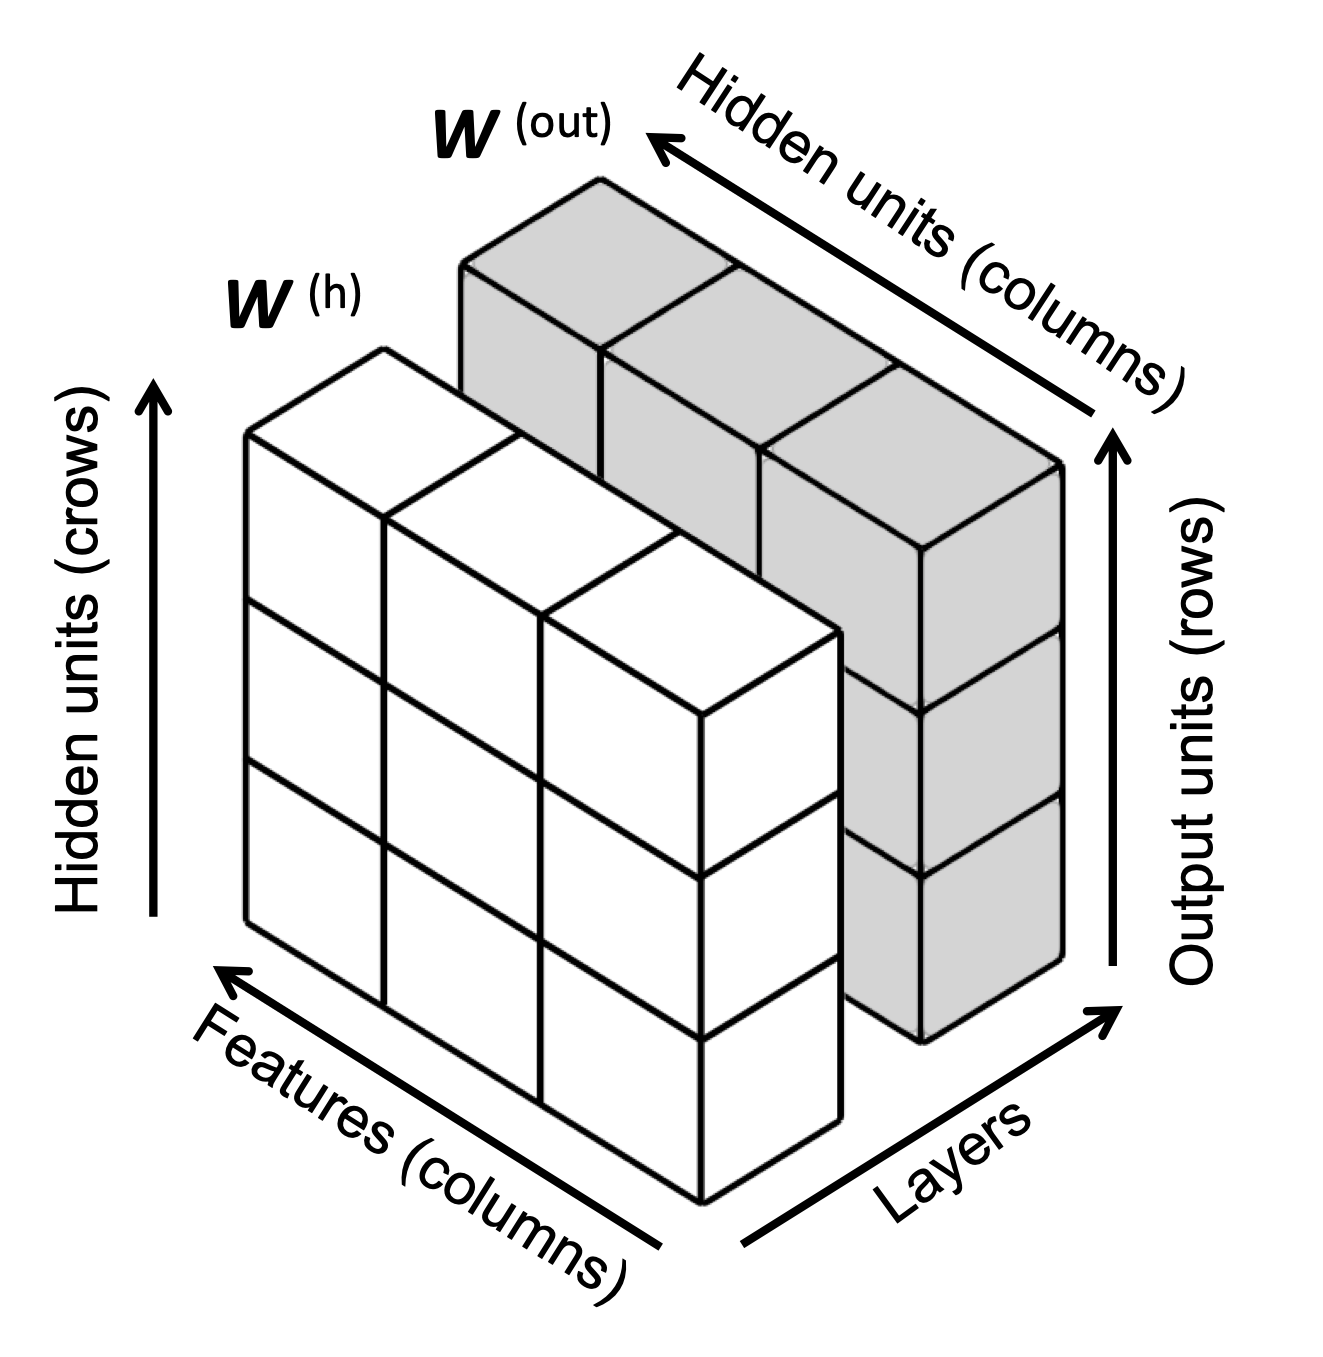

In [ ]:
Image(filename='figures/11_10.png', width=300)

<br>
<br>

## Developing your intuition for backpropagation

...

## Training neural networks via backpropagation

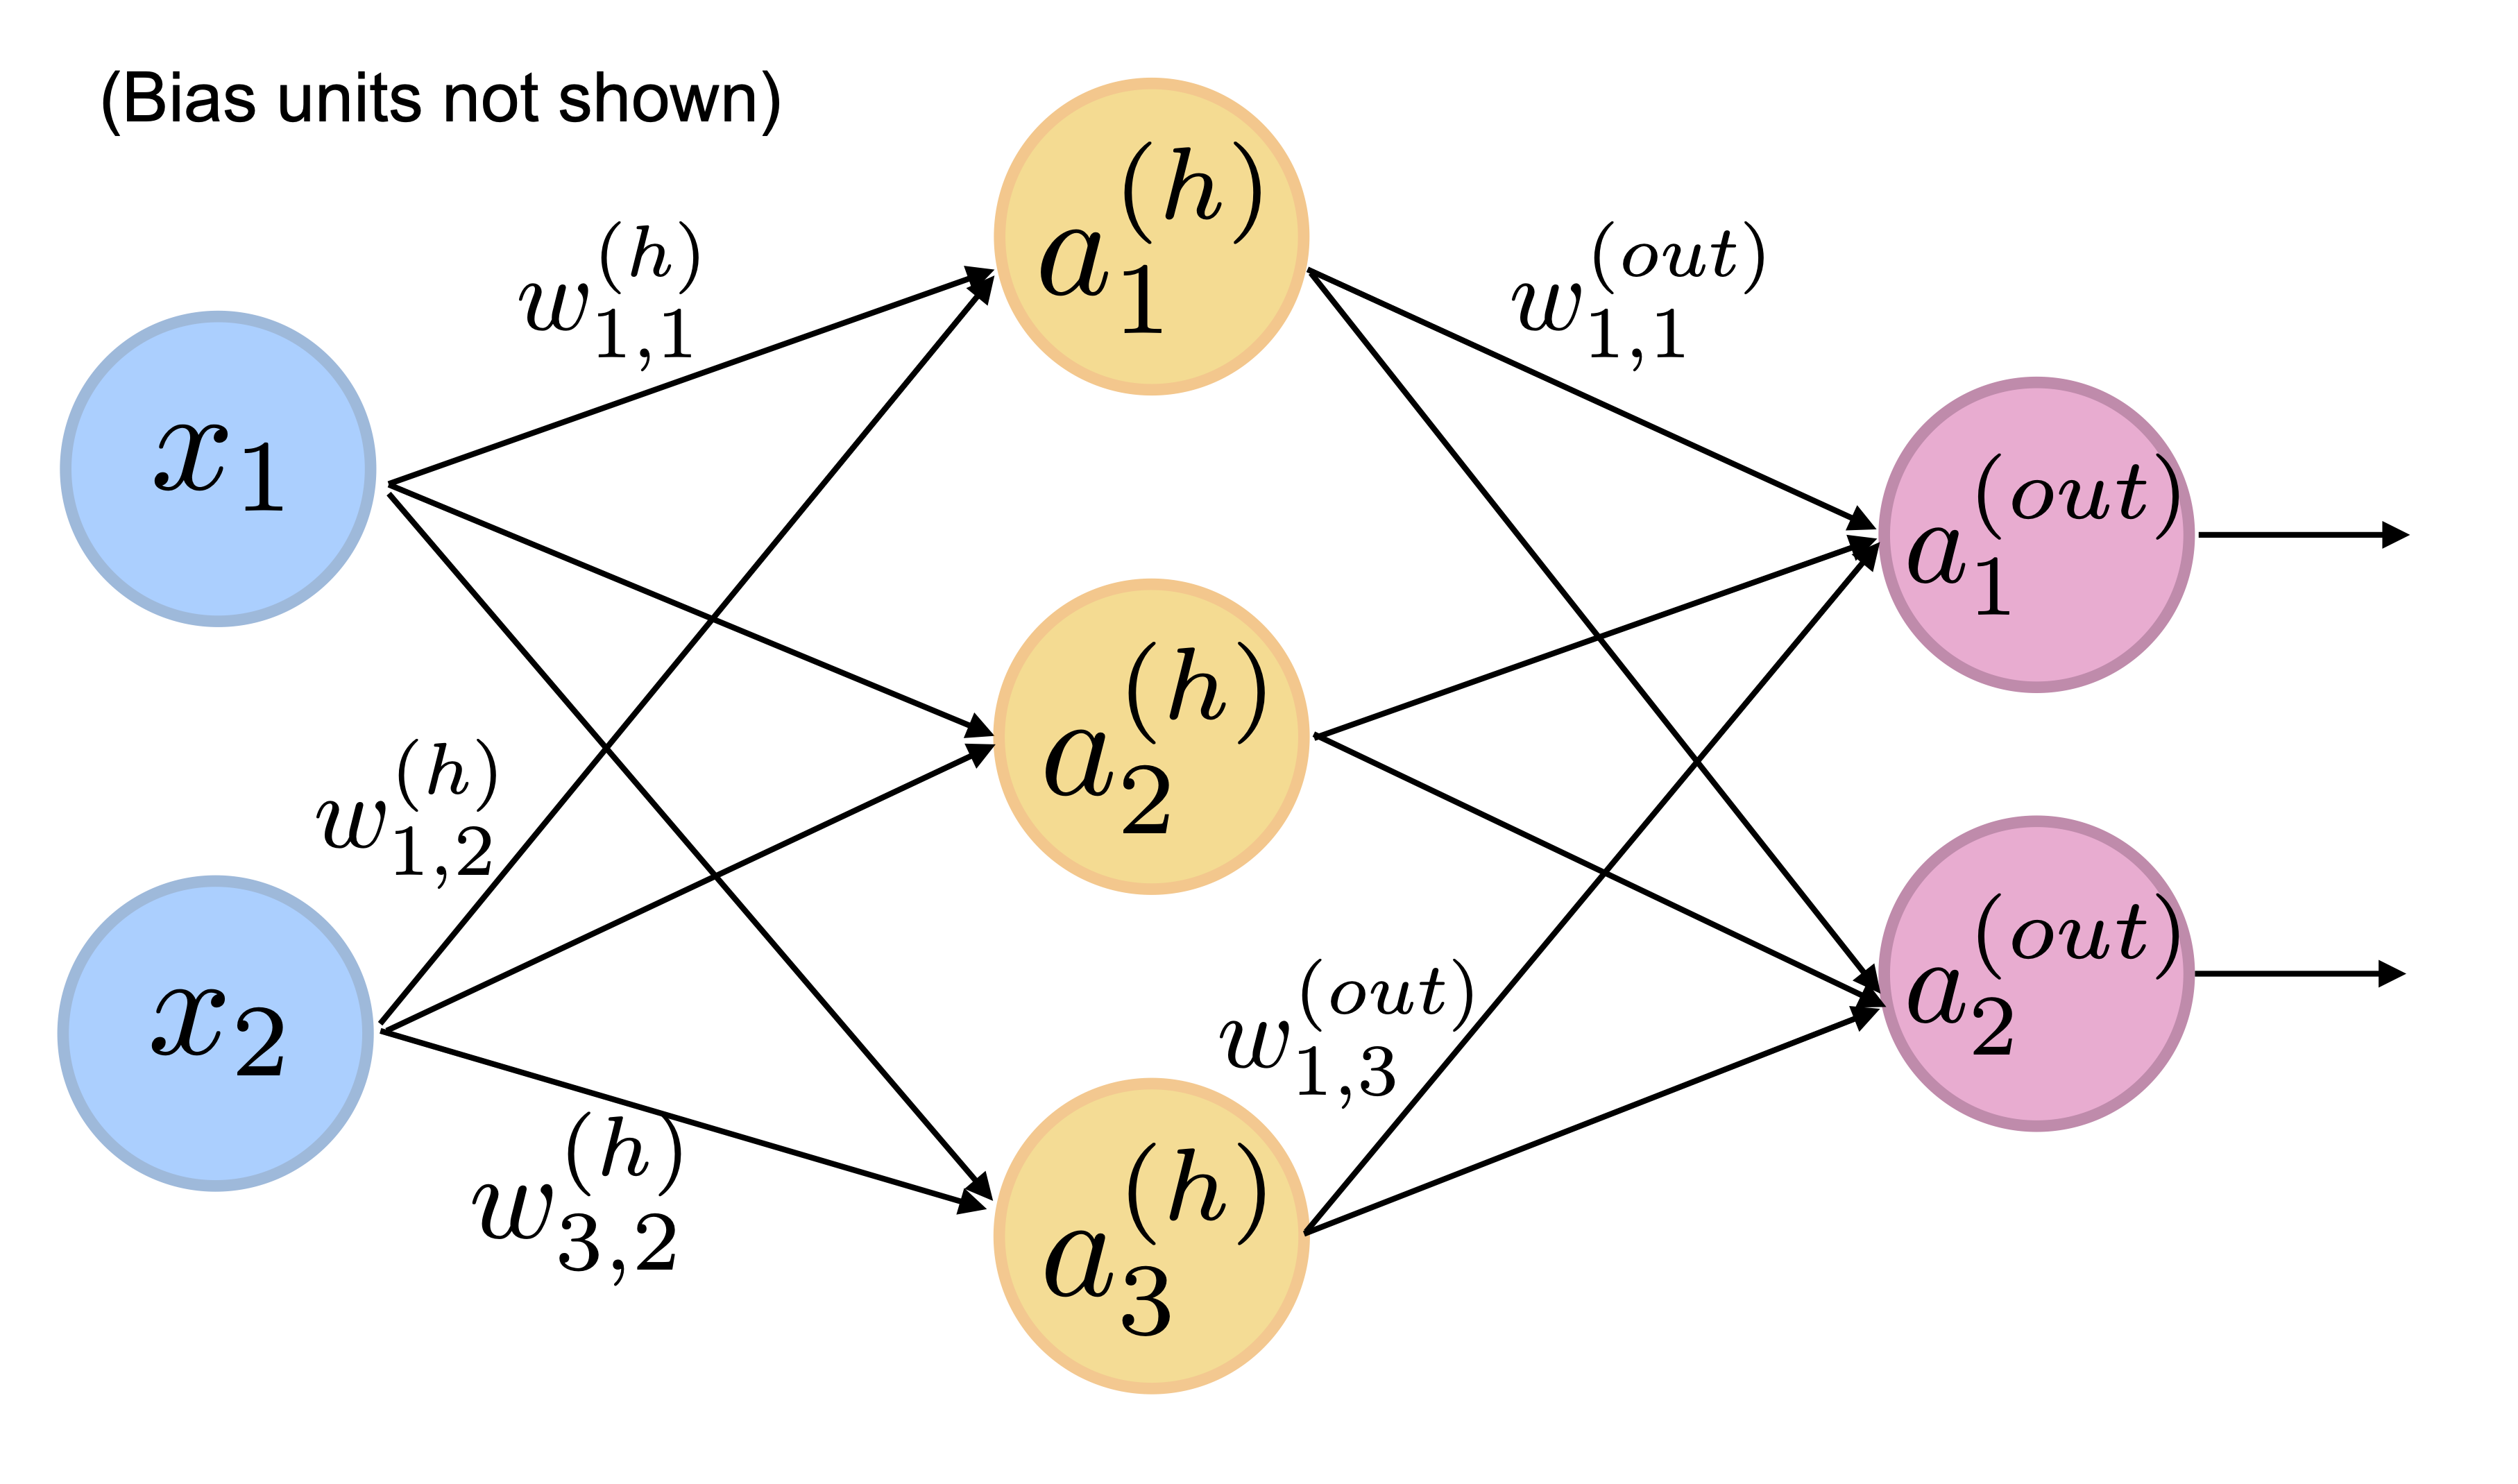

In [ ]:
Image(filename='./figures/11_11.png', width=400)

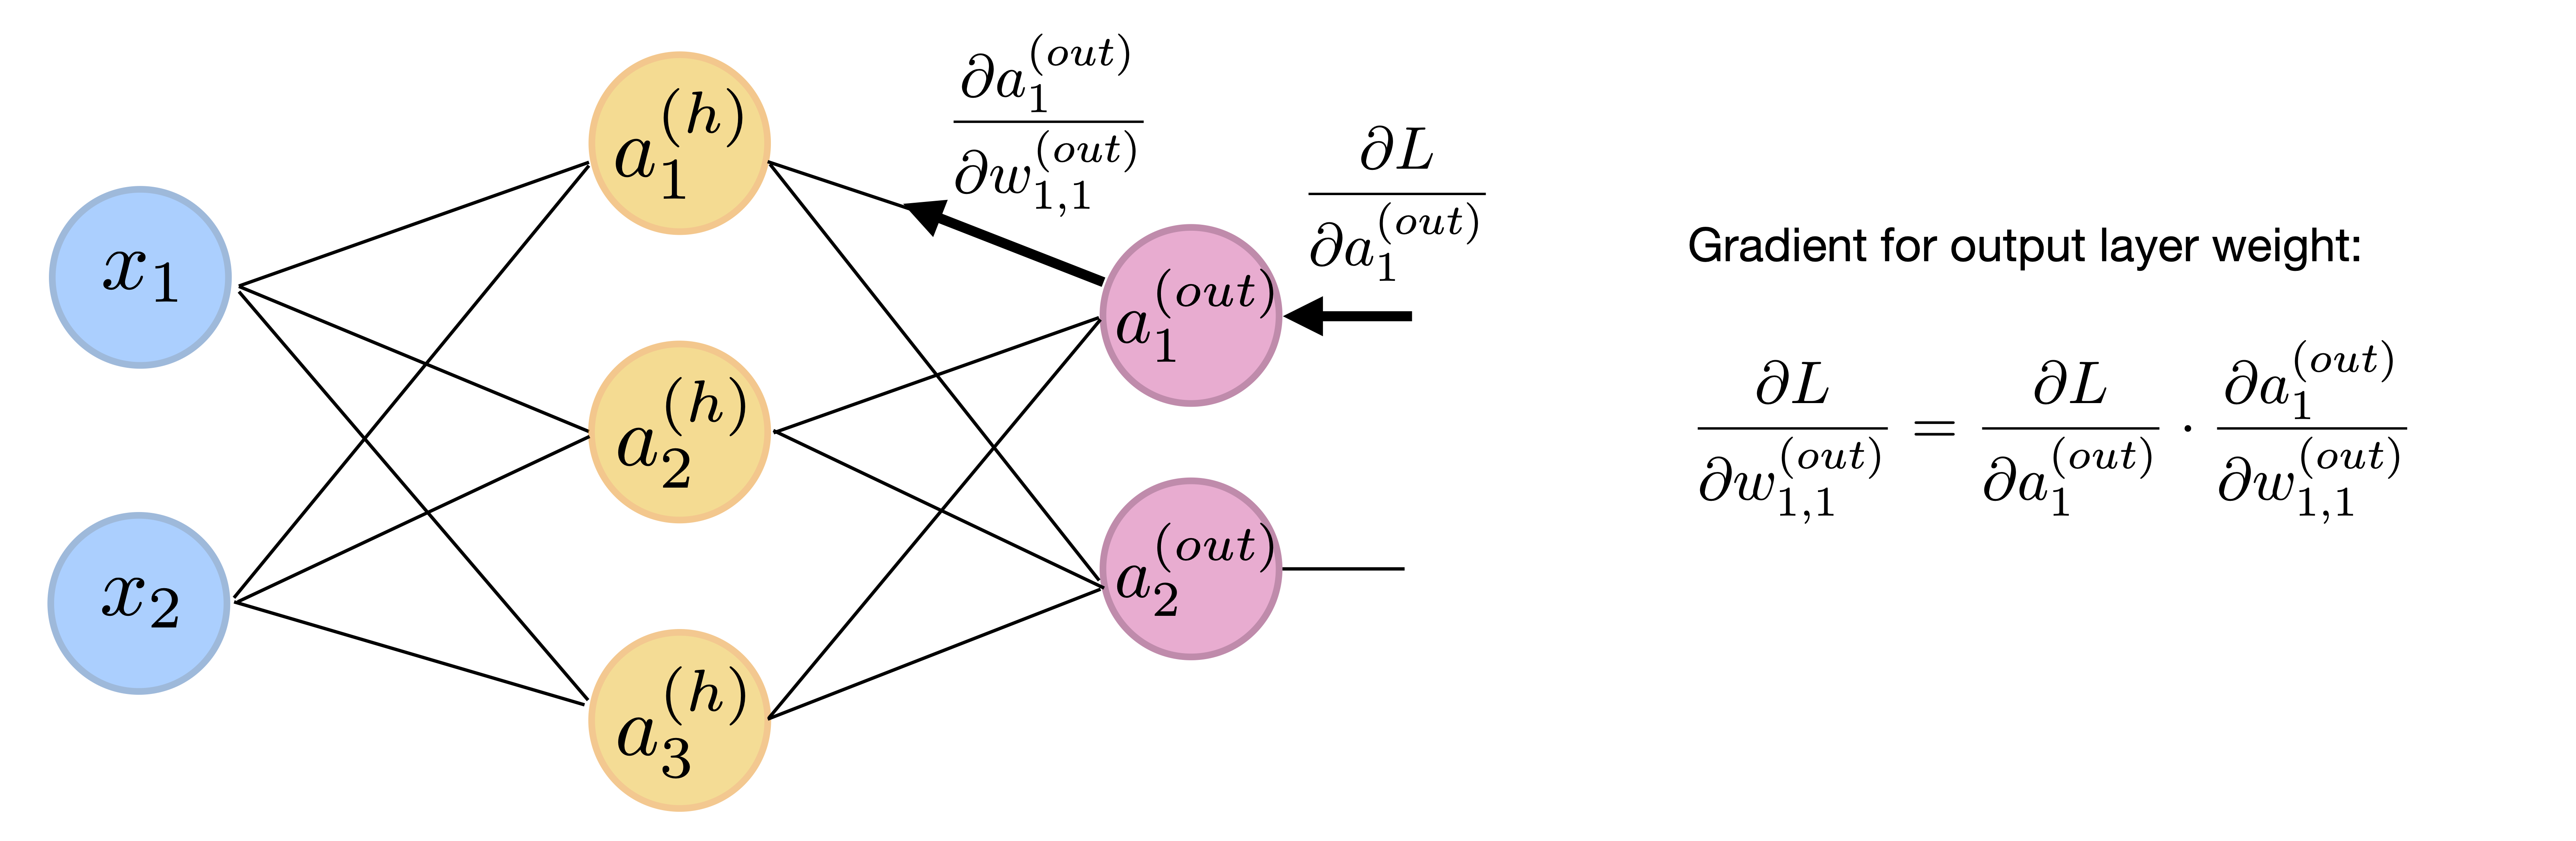

In [ ]:
Image(filename='figures/11_12.png', width=500)

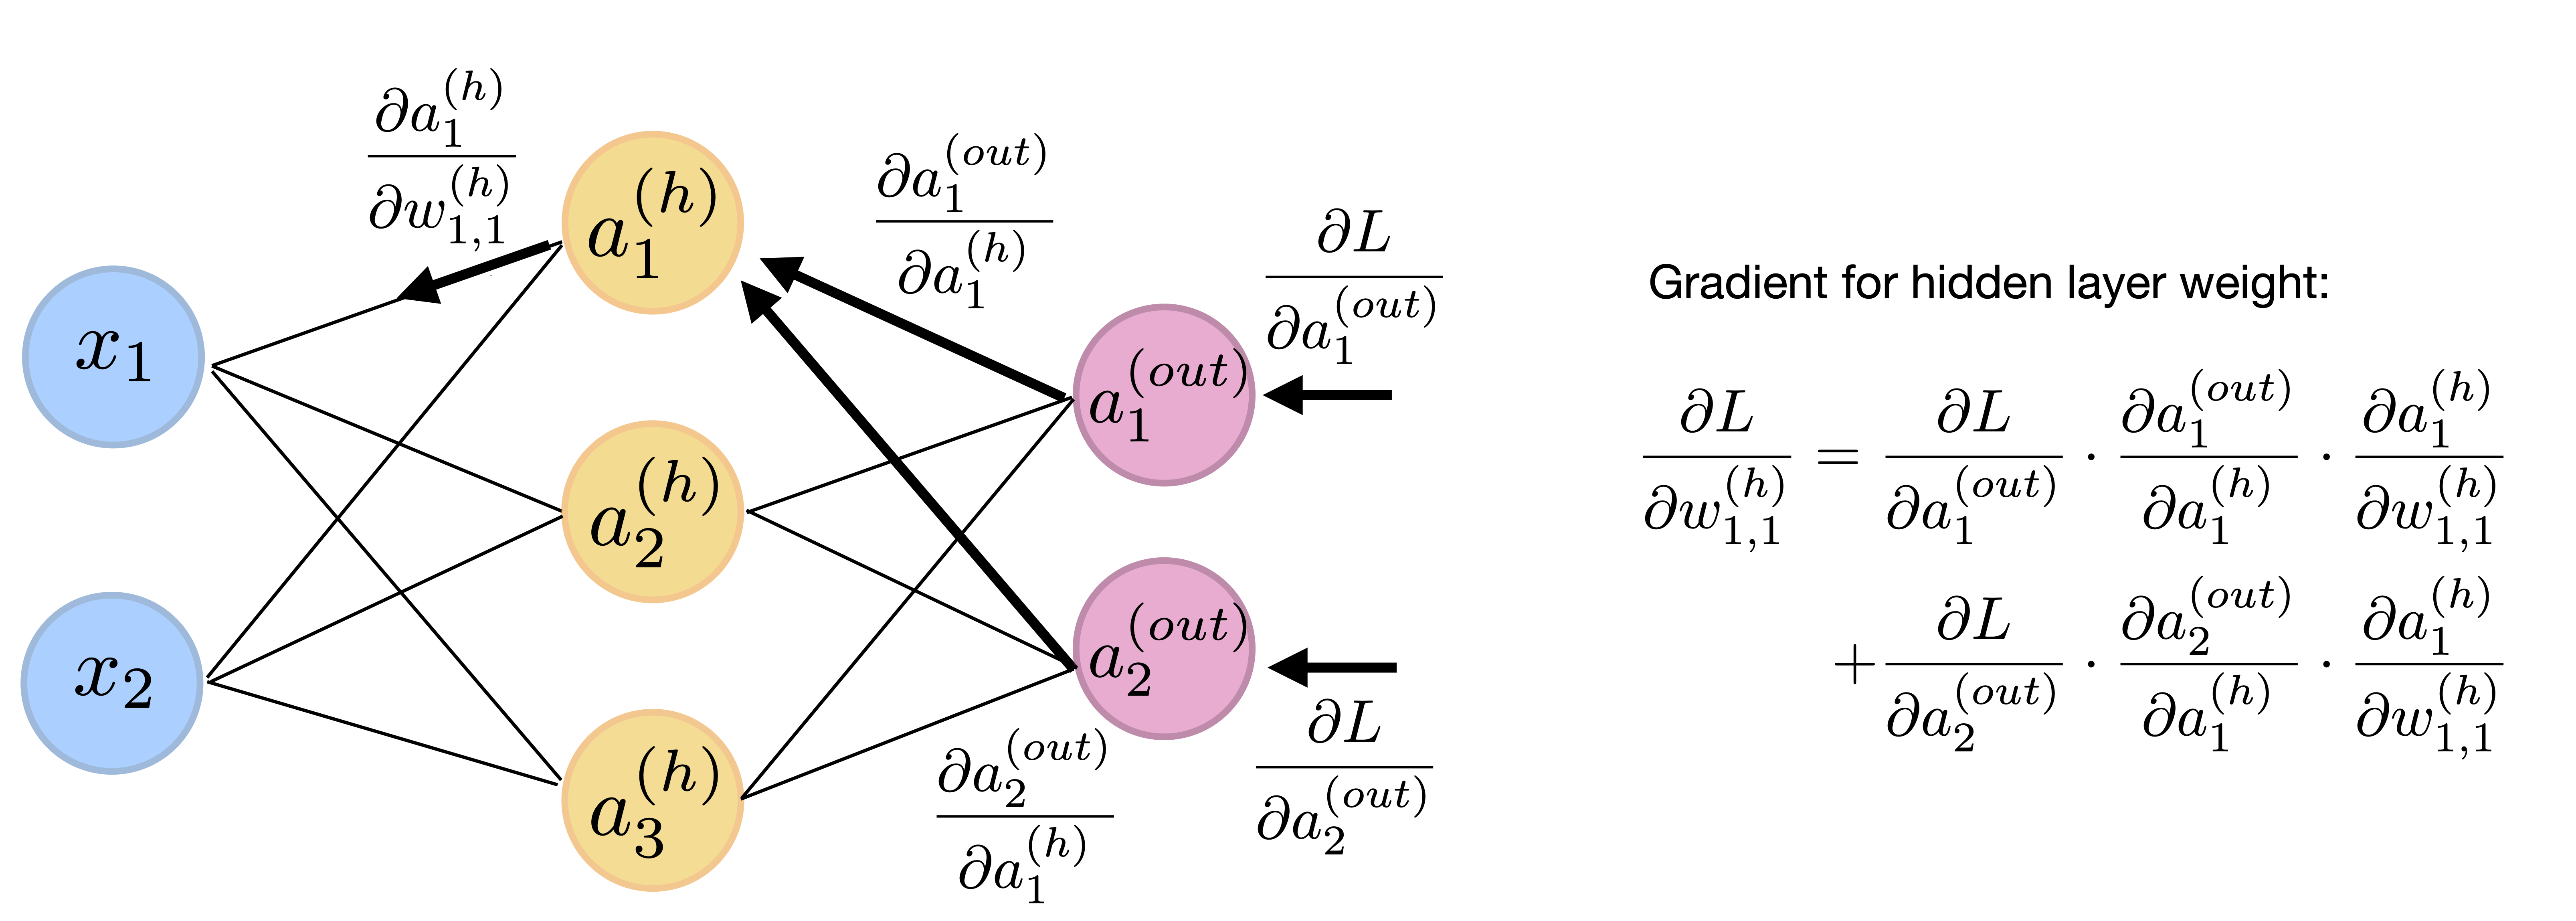

In [ ]:
Image(filename='figures/11_13.png', width=500)

<br>
<br>

# Convergence in neural networks

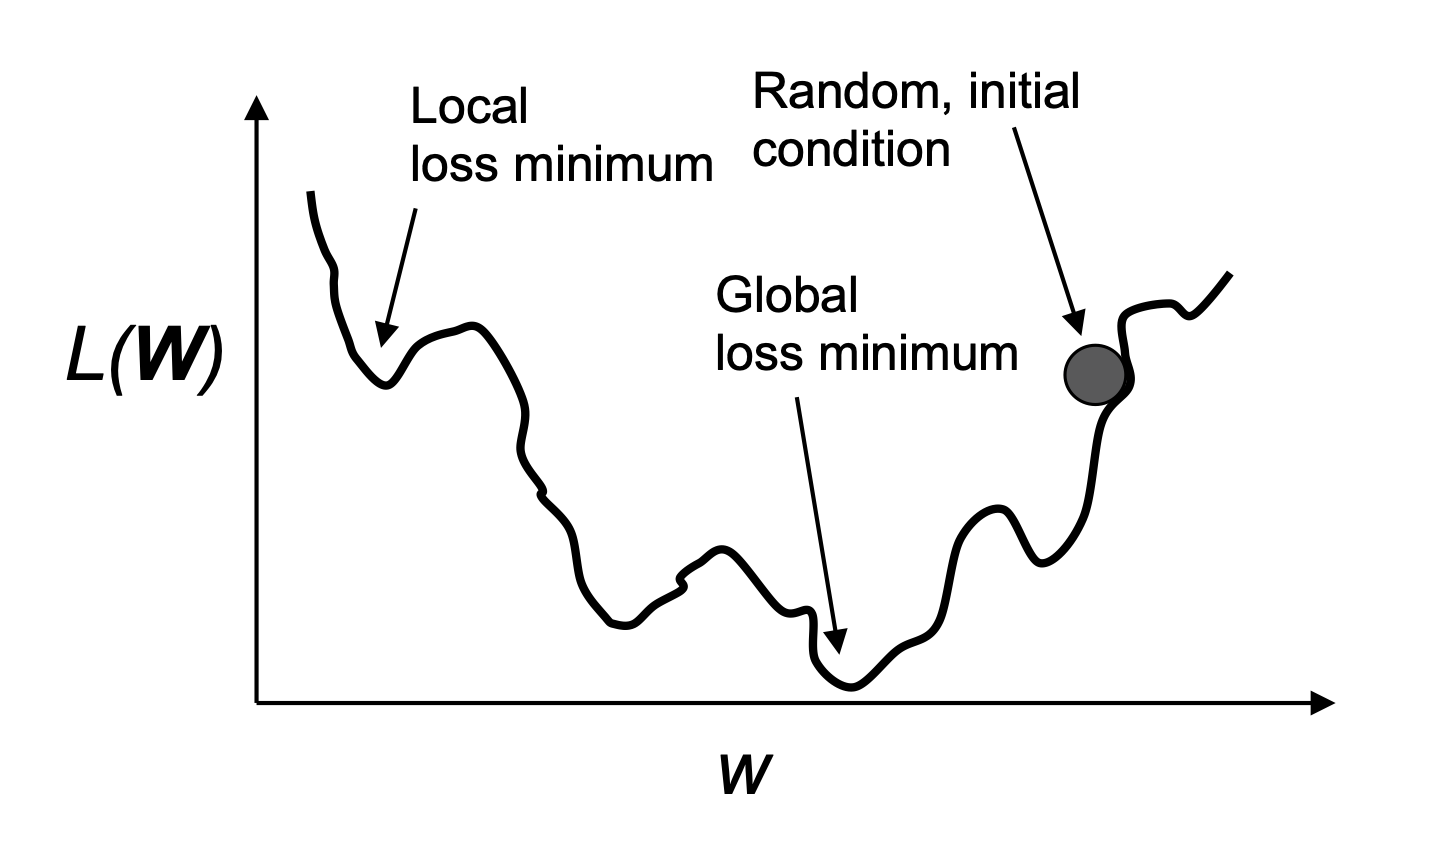

In [ ]:
Image(filename='figures/11_14.png', width=500)

<br>
<br>

...

# Summary

...

---

Readers may ignore the next cell.

In [ ]:
! python ../.convert_notebook_to_script.py --input ch11.ipynb --output ch11.py

[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook ch11.ipynb to script
[NbConvertApp] Writing 14525 bytes to ch11.py
